# Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)
Let $f_{\theta}(x)$ be a polynomial regression model as in the previous Homework, and let the poly_regression_small.csv from Virtuale be the training set. Then, sample 20% of the data in the poly_regression_large.csv dataset to use as test set.

- For a given value of $K$, write three Python functions computing $\theta_{MLE}$, i.e. the optimal parameters obtained by optimizing the MLE-related loss function with Gaussian assumption on the likelihood $p_{\theta}(y|x)$, by Gradient Descent, Stochastic Gradient Descent (with a batch_size = 5), and Normal Equations method with Cholesky Decomposition.

- Compare the performance of the three regression model computed above. In particular, if $(X_{test}, Y_{test})$
 is the test set from the poly_regression_large.csv dataset, for each of the model, compute:
$$ Err = \frac 1{N_{test}}\sum_{i=1}^{N_{test}}(f_{\theta}(x^i) - y^i)^2 $$ 
where $N_{test}$ is the number of elements in the test set, $(x^i,y^i)$ are the input and output elements in the test set. Comment the performance of the three models.


- For different values of $K$, plot the training datapoints and the test datapoints with different colors and visualize (as a continuous line) the three learned regression model $f_{\theta}(x)$. Comment the results.

- For increasing values of $K$, compute the training and test error as discussed above. Plot the two errors with respect to $K$. Comment the results.

- Repeat the same experiments by considering the MAP formulation with Gaussian assumption on the prior term $p(\theta)$. Set $K=8$ and test different values of $\lambda>0$ in the experiments. Comment the results, comparing:

    - the three optimization method used to obtain $\theta_{MAP}$ (i.e. GD, SGD and Normal Equations),

    - the different values of $\lambda>0$ tested,

    - the results obtained by $\theta_{MLE}$ vs $\theta_{MAP}$.

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [184]:
# for training set
data_small = pd.read_csv('./data/poly_regression_small.csv')
# for testing set
data_large = pd.read_csv('./data/poly_regression_large.csv')

x_train = np.array(data_small['x'])
y_train = np.array(data_small['y'] )

x_test = np.array(data_large['x'])
y_test = np.array(data_large['y'])

print(x_train.shape, x_test.shape)

(50,) (1000,)


In [185]:
# take the 20% of the test set 
n_test = int(0.2 * x_test.shape[0])

# Split testing set from large dataset
def test_split_data(X, Y, n_test):    
    N = X.shape[0]  
    idx = np.arange(N)  
    np.random.shuffle(idx)  
    
    test_idx = idx[:n_test]  

    X_test = X[test_idx]
    Y_test = Y[test_idx]
    
    return (X_test, Y_test)


(X_test, Y_test) = test_split_data(x_test, y_test, n_test)

print(X_test.shape, Y_test.shape)

(200,) (200,)


*Remark*: the polynomial regression model is $f_\theta(x) = \phi^T(x) \theta$, where each $\phi(x)$ is an element of the Vandermond matrix:
$$ \Phi(X) = [\phi_1(X) \phi_2(X) \dots \phi_K(X)] \in \mathbb{R}^{N \times K} $$
with:
$$ \begin{split}
    \Phi(X) = \begin{bmatrix}
    1 & (x^1) & (x^1)^2 & \dots & (x^1)^{K-1} \\
    1 & (x^2) & (x^2)^2 & \dots & (x^2)^{K-1} \\
    \vdots & \vdots & \vdots & \dots & \vdots \\
    1 & (x^N) & (x^N)^2 & \dots & (x^N)^{K-1} \\
    \end{bmatrix} \in \mathbb{R}^{N \times K}
\end{split}$$

In [186]:
# polynomial regression model implementation
def f(x, theta, K):
    PhiX = vandermonde(x, K)
    return PhiX@theta

# defining the Vandermonde matrix, N rows, K columns
# i use this definition instead of (K,N) in order to use PhiX instead of PhiX.T
def vandermonde(x, K):
    N = x.shape[0]
    PhiX = np.zeros((N, K))
    for j in range(K):
       PhiX[:, j] = x**j  # in this way the first columun (j=0) has all x**0=1s, and so on
    return PhiX


As we are supposing that the likelihood $p_\theta(y|x)$ has Gaussian distribution, we know that
$$ \theta_{MLE} = \arg\min_{\theta \in \mathbb{R}^s} \sum_{i=1}^N \frac{1}{2} (y^i - f_\theta(x^i))^2 $$
which can be reformulated as the Least Squares problem:
$$ \theta_{MLE} = \arg\min_{\theta \in \mathbb{R}^s} \frac{1}{2} || f_\theta(X) - Y ||_2^2. $$

As we are considering a polynomial regression model, and we are assuming that 
$$ p_\theta(y|x) = \mathcal{N}(\phi^T(x) \theta, \sigma^2) $$
then the MLE-related training problem reads:
$$ \theta_{MLE} = \arg\min_{\theta \in \mathbb{R}^K} \frac{1}{2} || \Phi(X) \theta - Y ||_2^2, $$
where $\Phi(x)$ is the Vandermonde matrix.

So, finding $\theta_{MLE}$ leads to a training procedure for a regression model. Indeed, it can be optimized by Gradient Descent (or its Stochastic variant), by solving:
$$ \begin{split}
    \begin{cases}
        \theta_0 \in \mathbb{R}^K \\
        \theta_{k+1} = \theta_k - \alpha_k \nabla_{\theta} (- \log p_{\theta_k}(y|x)) = \theta_k - \alpha_k \Phi(X)^T (\Phi(X) \theta - Y).
    \end{cases}
\end{split} $$

In [187]:
def backtracking(f, grad_f, theta, X, y, K, lambda_map=0):
    # Initial step size
    alpha = 1
    # Parameters for backtracking search
    c = 0.8
    tau = 0.25
    
    # Compute the initial loss and gradient at theta
    grad = grad_f(theta, X, y, K, lambda_map)
    
    # Backtracking search loop
    while f(theta - alpha * grad, X, y, K, lambda_map) > f(theta, X, y, K, lambda_map) - c * alpha * np.linalg.norm(grad, 2) ** 2:
        alpha = tau * alpha  # Reduce alpha
        
    return alpha

In [188]:
# added lambda_map=0 in order to use the same GD,SGD functions for both MLE and MAP

# loss function: 1/2 ||PhiX*theta - Y||^2
def loss(theta, X, y, K, lambda_map=0):
    y_pred = f(X, theta, K)
    error = y_pred - y
    return 0.5 * np.linalg.norm(error, 2) ** 2

# grad_loss function: PhiX.T (PhiX theta - Y)
def grad_loss(theta, X, y, K, lambda_map=0):
    PhiX = vandermonde(X, K)
    return PhiX.T @ (PhiX @ theta - y)
    

def GD(loss, grad_loss, D, theta0, K,lambda_map = 0, maxit = 1000, tolf=1e-5, tolx=1e-5):
    X, y = D  # Unpack the data
    d = theta0.shape[0] # While theta0 has shape (d, )

    # Initialization of history vectors
    theta_history = np.zeros((maxit+1, d))  # Save parameters at each iteration
    grad_norm_history = np.zeros((maxit+1, ))  # Save gradient norms at each iteration
    
    # keep track of theta values 
    theta_history[0] = theta0
    # keep track of the gradient values (for the stopping criteria)
    gradient = grad_loss(theta0, X, y, K, lambda_map)
    grad_norm_history[0] = np.linalg.norm(gradient, 2)
    
    for k in range(maxit):
        # Update weights
        alpha = backtracking(loss, grad_loss, theta0, X, y, K, lambda_map)
        theta = theta0 - alpha * gradient
        
        # Compute the gradient of the loss
        gradient = grad_loss(theta, X, y, K, lambda_map)

        # Save the updated values
        theta_history[k+1] = theta
        grad_norm_history[k+1] = np.linalg.norm(gradient)
        
        # stopping condition
        if np.linalg.norm(gradient, 2) < tolf*grad_norm_history[0] or np.linalg.norm(theta-theta0, 2)<tolx:
            break
        
        # update theta
        theta0 = theta
        
    theta_history = theta_history[:k+1] 
    grad_norm_history = grad_norm_history[:k+1]
    
    return theta_history, alpha, k

def GD_call(K=4):
    theta0 = np.ones((K,))
    theta_history, alpha, k = GD(loss, grad_loss, (x_train, y_train), theta0, K=4)
    return theta_history, alpha, k

In [189]:
GD_theta_history, a, k = GD_call()
print(f"GD: The best set of parameters theta found is: {GD_theta_history[-1]}, with alpha = {a} e k = {k}")

GD: The best set of parameters theta found is: [-0.16585434  1.42184751  2.48961651 -2.58268641], with alpha = 0.00390625 e k = 999


Now we repeat the same process using the Stochastic Gradient Descent SGD

In [ ]:
def SGD(loss, grad_loss, D, theta0, alpha, K, lambda_map = 0,batch_size=5, n_epochs=100):
    X, y = D  # Unpack the data
    N = X.shape[0] # We assume both X and Y has shape (N, )
    d = theta0.shape[0] # While theta0 has shape (d, )
    idx = np.arange(0, N) # This is required for the shuffling
    
    # Initialization of history vectors
    theta_history = np.zeros((n_epochs, d))  # Save parameters at each epoch
    loss_history = np.zeros((n_epochs, ))  # Save loss values at each epoch
    grad_norm_history = np.zeros((n_epochs, ))  # Save gradient norms at each epoch
    
    # Initialize weights
    theta = theta0
    for epoch in range(n_epochs):
        # Shuffle the data at the beginning of each epoch
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Initialize a vector that saves the gradient of the loss at each iteration
        grad_loss_vec = []

        for batch_start in range(0, N, batch_size):
            batch_end = min(batch_start + batch_size, N)
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]
            
            # Compute the gradient of the loss
            gradient = grad_loss(theta, X_batch, y_batch, K, lambda_map)
            grad_loss_vec.append(np.linalg.norm(gradient, 2))


            # Update weights
            theta = theta - alpha * gradient

        # Save the updated values
        theta_history[epoch] = theta
        loss_history[epoch] = loss(theta, X, y, K, lambda_map)
        grad_norm_history[epoch] = np.mean(grad_loss_vec)
    
    return theta_history, loss_history, grad_norm_history


def SGD_call(K=4):
    theta0 = np.ones((K,))
    theta_history, loss_history, grad_norm_history = SGD(loss, grad_loss, (x_train, y_train), theta0, alpha=0.01, K=4)
    return theta_history, loss_history, grad_norm_history


In [191]:
SGD_theta_history, SGD_loss_history, SGD_grad_norm_history = SGD_call()
print(f"SGD: The best set of parameters theta found is: {SGD_theta_history[-1]}")

SGD: The best set of parameters theta found is: [0.0792246  0.9577596  0.45884856 0.02012435]


Finally, repeat for the last time this process by using the Normal Equations method with Cholesky Decomposition.

As the optimization problem defining $\theta_{MLE}$ is a least square problem, it can also be solved by considering the Normal Equations method, i.e.
$$ \theta_{MLE} = (\Phi(X)^T \Phi(X))^{-1} \Phi(X)^T Y. $$

In [192]:
def cholesky_met(X, Y, K):
    # Step 1: compute vandermonde matrix
    PhiX = vandermonde(X, K)
    
    # Step 2: perform Cholesky decomposition on Phi(X)^T * Phi(X)
    L = np.linalg.cholesky(PhiX.T @ PhiX)

    # Step 3: solve the system Lz = Phi(X)^T * Y using forward substitution
    z = np.linalg.solve(L, PhiX.T @ Y)

    # Step 4: solve the system L^T * theta = z using backward substitution
    theta = np.linalg.solve(L.T, z)

    return theta
    

cholesky_theta = cholesky_met(x_train, y_train, 4)
print(f"the best set of parameters theta is: {cholesky_theta}")

the best set of parameters theta is: [ 0.07903542 -1.47472763  9.51845896 -7.14903107]


Now, let's compute the Mean Square Error in order to compare the performance of three regression models computed above.

In [193]:
# compute MSE as Err = \frac 1{N_{test}}\sum_{i=1}^{N_{test}}(f_{\theta}(x^i) - y^i)^2 

def compute_mse(y_true, y_pred):
    N_test = y_true.shape[0]
    return np.sum((y_pred - y_true) ** 2) / N_test

# in order to compare the models, i will use the Test Set
def compare_models(X_test, Y_test, GD_theta_history, SGD_theta_history, cholesky_theta, K):
    # Compute the predictions for each model
    y_pred_gd = f(X_test, GD_theta_history, K) 
    y_pred_sgd = f(X_test, SGD_theta_history, K) 
    y_pred_cholesky = f(X_test, cholesky_theta, K)

    # compute the Mean Square Error for each model
    mse_gd = compute_mse(Y_test, y_pred_gd)
    mse_sgd = compute_mse(Y_test, y_pred_sgd)
    mse_cholesky = compute_mse(Y_test, y_pred_cholesky)


    print(f"Mean Squared Error (GD): {mse_gd}")
    print(f"Mean Squared Error (SGD): {mse_sgd}")
    print(f"Mean Squared Error (Normal Equation): {mse_cholesky}")

    # Perfomance
    if mse_gd < mse_sgd and mse_gd < mse_cholesky:
        print("Gradient Descent performs best.")
    elif mse_sgd < mse_gd and mse_sgd < mse_cholesky:
        print("Stochastic Gradient Descent performs best.")
    else:
        print("Normal Equation performs best.")
        
    
GD_theta_history_best, SGD_theta_history_best = GD_theta_history[-1], SGD_theta_history[-1]
compare_models(X_test, Y_test, GD_theta_history_best, SGD_theta_history_best, cholesky_theta, K=4)

Mean Squared Error (GD): 0.012155282965831161
Mean Squared Error (SGD): 0.038637581214680826
Mean Squared Error (Normal Equation): 0.008657392724364605
Normal Equation performs best.



Now, for different values of $K$, plot the training datapoints and the test datapoints with different colors and visualize (as a continuous line) the three learned regression model $f_{\theta}(x)$. 

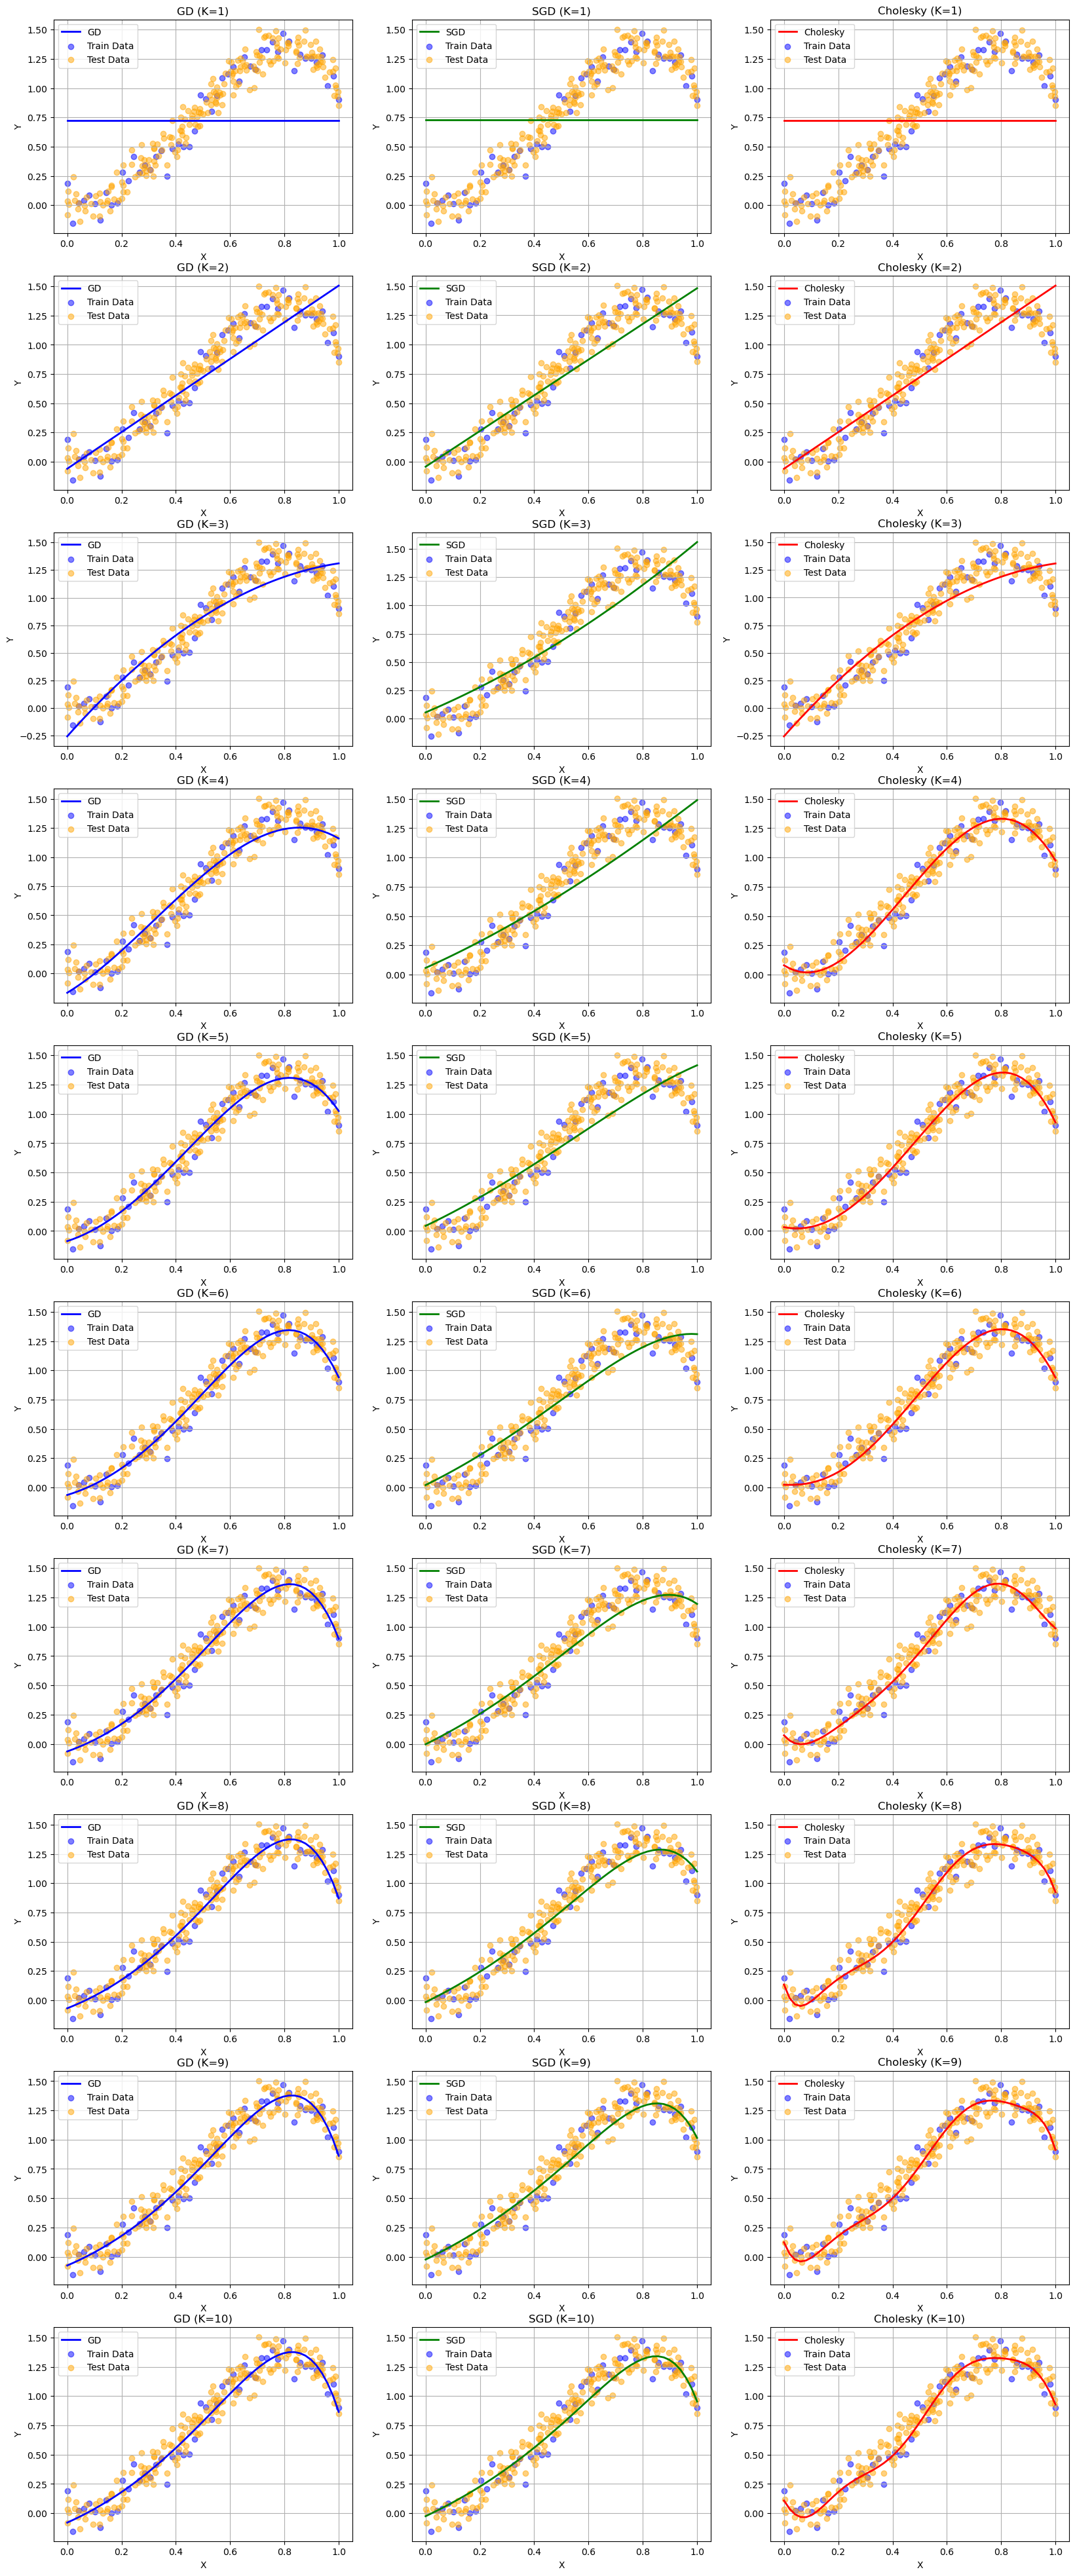

In [194]:
## i use plt.scatter just to make more readable the training and data set plot

def plotting_func(X_train, Y_train, X_test, Y_test):
    # Test K values from 1 to 10
    K_values = range(1, 11)  
    alpha = 0.01
    plt.figure(figsize=(20, len(K_values) * 5))  
    

    for i, k in enumerate(K_values):
        # Initialize theta as a zero vector
        theta0 = np.zeros((k,))
        
        # Perform regression using GD, SGD, and Cholesky
        # use '_' because i do not care about the other values the GD and SGD are returning
        GD_theta_history, _, _ = GD(loss, grad_loss, (X_train, Y_train), theta0, k)
        SGD_theta_history, _, _ = SGD(loss, grad_loss, (X_train, Y_train), theta0, alpha, k)
        cholesky_theta = cholesky_met(X_train, Y_train, k)

        # Generate predictions for each method
        # i use the notation with [-1] because the last set of the parameters
        # should be the best one
        y_gd = f(X_train, GD_theta_history[-1], k)          
        y_sgd = f(X_train, SGD_theta_history[-1], k)        
        y_cholesky = f(X_train, cholesky_theta, k)    
        
        # **Column 1:** Plot GD results
        plt.subplot(len(K_values), 3, i * 3 + 1)  
        
        plt.plot(X_train, y_gd, label='GD', color='blue', linewidth=2)  
        plt.scatter(X_train, Y_train, color='blue', label='Train Data', alpha=0.5)  
        plt.scatter(X_test, Y_test, color='orange', label='Test Data', alpha=0.5)   
        
        plt.title(f'GD (K={k})')  
        plt.xlabel('X')           
        plt.ylabel('Y')           
        plt.legend()              
        plt.grid(True)            

        # **Column 2:** Plot SGD results
        plt.subplot(len(K_values), 3, i * 3 + 2)  
        
        plt.plot(X_train, y_sgd, label='SGD', color='green', linewidth=2) 
        plt.scatter(X_train, Y_train, color='blue', label='Train Data', alpha=0.5)  
        plt.scatter(X_test, Y_test, color='orange', label='Test Data', alpha=0.5)   
        
        plt.title(f'SGD (K={k})')  
        plt.xlabel('X')           
        plt.ylabel('Y')           
        plt.legend()              
        plt.grid(True)            

        # **Column 3:** Plot Cholesky results
        plt.subplot(len(K_values), 3, i * 3 + 3) 
        
        plt.plot(X_train, y_cholesky, label='Cholesky', color='red', linewidth=2)  
        plt.scatter(X_train, Y_train, color='blue', label='Train Data', alpha=0.5)  
        plt.scatter(X_test, Y_test, color='orange', label='Test Data', alpha=0.5)   
        
        plt.title(f'Cholesky (K={k})')  
        plt.xlabel('X')           
        plt.ylabel('Y')           
        plt.legend()              
        plt.grid(True)            
    

    plt.show()


(X_test, Y_test) = test_split_data(x_test, y_test, n_test)

plotting_func(x_train, y_train, X_test, Y_test)


In the three models, we have similar behaviours:
- GD (Gradient Descent): Generally, GD may require more iterations to converge, especially with noisy or large datasets. But as we can see from the plots, it's very well-behaving for both training and test set.
    - I have used backtracking method to find $\alpha$.
- SGD (Stochastic Gradient Descent): SGD might be faster for large datasets since it updates the parameters after each mini-batch. However, it could be more noisy and less stable compared to batch methods like GD. 
    - We can see this behaviour just comparig the GD plot and SGD plot for $K=5$: the difference is evident.
    
- Normal Equation: This is a closed-form solution that doesn’t require iterative optimization, and it is typically faster for small datasets. 
    - From the plot, for $K\ge 8$, it looks like that the model has learnt the noise, and this is not optimal.

Moreover, we can notice that for $K \ge 8$ the polynomial functions do not change. This means that we could have an accurate results just setting $K=4$ for GD and Cholesky models, while  $K=8$ for SGD model.

Now, for increasing values of $K$, compute the training and test error as discussed above. Plot the two errors with respect to $K$. Comment the results.

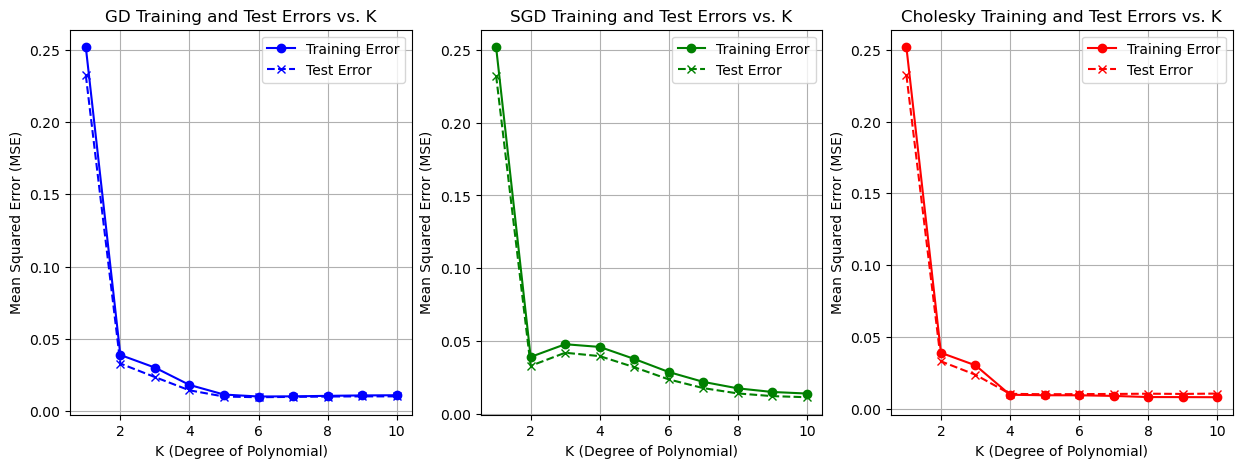

In [195]:
def plotting_err(X_train, Y_train, X_test, Y_test):
    K = [k for k in range(1, 11)]  # Test values of K from 1 to 10
    training_errors_gd = []
    test_errors_gd = []
    training_errors_sgd = []
    test_errors_sgd = []
    training_errors_cholesky = []
    test_errors_cholesky = []
    
    plt.figure(figsize=(15,5))
    # Loop over the different values of K
    for k in K:
        # Initialize theta for GD and SGD
        theta0 = np.zeros((k,))

        # Perform regression using GD, SGD, and Cholesky
        # i will use the theta found in the training part to compute both
        # training error (using train set) and testing error (using test set)
        GD_theta_history, _, _, = GD(loss, grad_loss, (X_train, Y_train), theta0, K=k)
        SGD_theta_history, _, _ = SGD(loss, grad_loss, (X_train, Y_train), theta0, alpha=0.01, K=k)
        cholesky_theta = cholesky_met(X_train, Y_train, k)

        # Compute predictions for each model with training set
        y_gd_train = f(X_train, GD_theta_history[-1], k)
        y_sgd_train = f(X_train, SGD_theta_history[-1], k)
        y_cholesky_train = f(X_train, cholesky_theta, k)
        
        # Compute training error
        mse_gd_train = compute_mse(Y_train, y_gd_train)
        mse_sgd_train = compute_mse(Y_train, y_sgd_train)
        mse_ne_train = compute_mse(Y_train, y_cholesky_train)
        
        
        # Compute predictions for each model with testing set
        y_gd_test = f(X_test, GD_theta_history[-1], k)
        y_sgd_test = f(X_test, SGD_theta_history[-1], k)
        y_cholesky_test = f(X_test, cholesky_theta, k)
        
        # Compute testing error
        mse_gd_test = compute_mse(Y_test, y_gd_test)
        mse_sgd_test = compute_mse(Y_test, y_sgd_test)
        mse_ne_test = compute_mse(Y_test, y_cholesky_test)

        # Store the errors for plotting
        training_errors_gd.append(mse_gd_train)
        test_errors_gd.append(mse_gd_test)
        training_errors_sgd.append(mse_sgd_train)
        test_errors_sgd.append(mse_sgd_test)
        training_errors_cholesky.append(mse_ne_train)
        test_errors_cholesky.append(mse_ne_test)

    # Plot the errors
    plt.subplot(1,3,1)
    plt.plot(K, training_errors_gd, label='Training Error', color='blue', marker='o')
    plt.plot(K, test_errors_gd, label='Test Error', color='blue', linestyle='dashed', marker='x')
    plt.title('GD Training and Test Errors vs. K')
    plt.xlabel('K (Degree of Polynomial)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1,3,2)
    plt.plot(K, training_errors_sgd, label='Training Error', color='green', marker='o')
    plt.plot(K, test_errors_sgd, label='Test Error', color='green', linestyle='dashed', marker='x')
    plt.title('SGD Training and Test Errors vs. K')
    plt.xlabel('K (Degree of Polynomial)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,3,3)
    plt.plot(K, training_errors_cholesky, label='Training Error', color='red', marker='o')
    plt.plot(K, test_errors_cholesky, label='Test Error', color='red', linestyle='dashed', marker='x')
    plt.title('Cholesky Training and Test Errors vs. K')
    plt.xlabel('K (Degree of Polynomial)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()
    


(X_test, Y_test) = test_split_data(x_test, y_test, n_test)
plotting_err(x_train, y_train, X_test, Y_test)

It seems that, for the GD and SGD methods, we do not have overfitting, since the train and test errors behave in the same way.
Instead, we have overfitting with the Cholesky method, as for $K\ge 6$ the training error is (slighty) smaller than the test error. We can observe this pattern also in the plot graph.

- Repeat the same experiments by considering the MAP formulation with Gaussian assumption on the prior term $p(\theta)$. Set $K=8$ and test different values of $\lambda>0$ in the experiments. Comment the results, comparing:

    - the three optimization method used to obtain $\theta_{MAP}$ (i.e. GD, SGD and Normal Equations),

    - the different values of $\lambda>0$ tested,

    - the results obtained by $\theta_{MLE}$ vs $\theta_{MAP}$.

In [196]:
# define loss e grad_loss function for MAP -> we have to add the prior term
def loss_MAP(theta, X, y, K, lambda_map):
    mle_loss = loss(theta, X, y, K)  
    
    # Regularization term
    regularization_param = (lambda_map / 2) * np.linalg.norm(theta)**2
    return mle_loss + regularization_param
    
def grad_loss_MAP(theta, X, y, K, lambda_map):
    mle_grad = grad_loss(theta, X, y, K)
      
    # Gradient of regularization term
    regularization_grad = lambda_map * theta  
    return mle_grad + regularization_grad
    
# now ricompute the Normal Equations method with Cholesky Decomposition
def cholesky_MAP(X, Y, K, lambda_map):
    # Step 1: compute vandermonde matrix
    PhiX = vandermonde(X, K)
    
    # Step 2: perform Cholesky decomposition on Phi(X)^T * Phi(X) + lambda * I
    # identity matrix
    I = np.eye(K)
    L = np.linalg.cholesky(PhiX.T @ PhiX + lambda_map*I)

    # Step 3: solve the system Lz = Phi(X)^T * Y using forward substitution
    z = np.linalg.solve(L, PhiX.T @ Y)

    # Step 4: solve the system L^T * theta = z using backward substitution
    theta = np.linalg.solve(L.T, z)

    return theta
    

cholesky_theta = cholesky_MAP(x_train, y_train, 4, 5)
print(cholesky_theta)

[0.25161296 0.52745843 0.37125868 0.22585238]


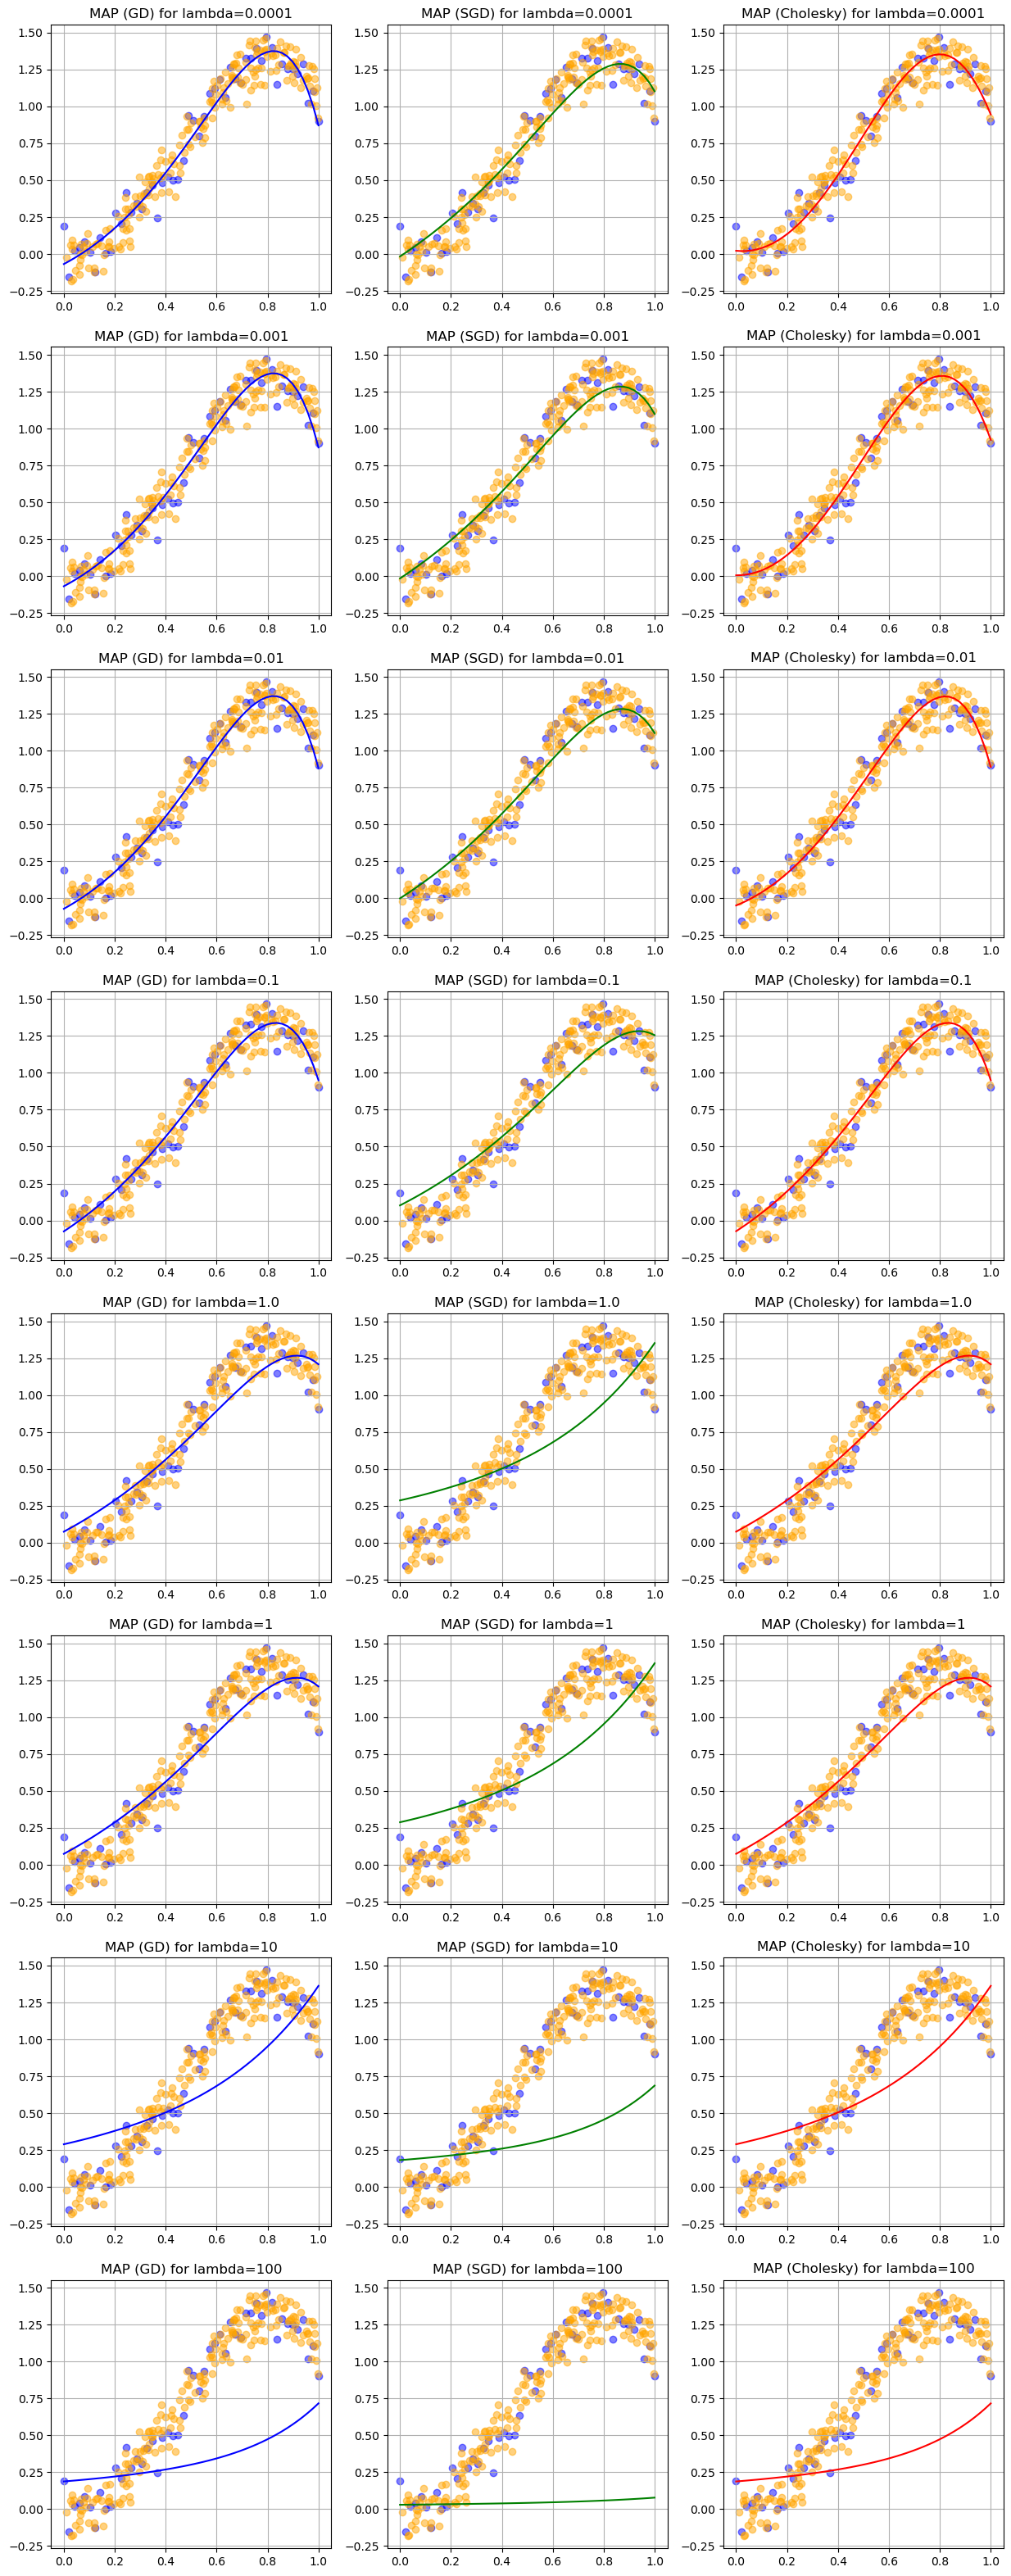

In [197]:
def map_experiments(X_train, Y_train, X_test, Y_test, lambda_values, K=8):
    """Run MAP experiments for different lambda values."""
    plt.figure(figsize=(15, len(lambda_values) * 5))
    alpha = 0.01
    
    for i, lambda_map in enumerate(lambda_values):
        # Initialize theta
        theta0 = np.zeros((K,))
        
        # Compute MAP solutions using GD, SGD, and Cholesky
        GD_theta_history, _, _, = GD(loss_MAP, grad_loss_MAP, (X_train, Y_train), theta0, K, lambda_map)
        SGD_theta_history, _, _ = SGD(loss_MAP, grad_loss_MAP, (X_train, Y_train), theta0, alpha, K, lambda_map)
        cholesky_theta = cholesky_MAP(X_train, Y_train, K, lambda_map)
        
        # Compute predictions
        y_gd = f(X_train, GD_theta_history[-1], K)
        y_sgd = f(X_train, SGD_theta_history[-1], K)
        y_cholesky = f(X_train, cholesky_theta, K)

        # Plot for the current lambda value
        plt.subplot(len(lambda_values), 3, i * 3 + 1)
        plt.plot(X_train, y_gd, label='GD', color='blue')
        plt.scatter(X_train, Y_train, color='blue', label='Train Data', alpha=0.5)  
        plt.scatter(X_test, Y_test, color='orange', label='Test Data', alpha=0.5)   
        plt.title(f'MAP (GD) for lambda={lambda_map}')
        plt.grid()
        
        plt.subplot(len(lambda_values), 3, i * 3 + 2)
        plt.plot(X_train, y_sgd, label='SGD', color='green')
        plt.scatter(X_train, Y_train, color='blue', label='Train Data', alpha=0.5)  
        plt.scatter(X_test, Y_test, color='orange', label='Test Data', alpha=0.5)   
        plt.title(f'MAP (SGD) for lambda={lambda_map}')
        plt.grid()
        
        plt.subplot(len(lambda_values), 3, i * 3 + 3)
        plt.plot(X_train, y_cholesky, label='Cholesky', color='red')
        plt.scatter(X_train, Y_train, color='blue', label='Train Data', alpha=0.5)  
        plt.scatter(X_test, Y_test, color='orange', label='Test Data', alpha=0.5)   
        plt.title(f'MAP (Cholesky) for lambda={lambda_map}')
        plt.grid()
        
    plt.show()
    

(X_test, Y_test) = test_split_data(x_test, y_test, n_test)
# for testing the behaviour with different values of lambda
lambda_values =  [10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1, 10, 100] 


map_experiments(x_train, y_train, X_test, Y_test, lambda_values)

We know that:
$$ \theta_{MAP} = \arg\min_{\theta \in \mathbb{R}^s} \sum_{i=1}^N \frac{1}{2\sigma^2} (f_\theta(x^i) - y^i )^2 + \frac{1}{2\sigma^2_\theta} ||\theta||_2^2 = \arg\min_{\theta \in \mathbb{R}^s} \frac{1}{2} || f_\theta(X) - Y ||_2^2 + \frac{\lambda}{2} || \theta ||_2^2. $$
So, the parameter $\lambda$ in the context of regularization is a hyperparameter that controls the influence of the regularization term on the model. The choice of $\lambda$ is crucial because it affects the balance between a model that fits the data too well (overfitting) and one that does not fit the data well enough (underfitting).
So, as we can see from the plots,:
- with small values of $\lambda$ the model resembles MLE, where regularization is minimal or absent. Indeed, we have similar behaviour with the three MLE models.
- with big values of $\lambda$ regularization is strong, and the solution approximates a simpler model with $\theta$ close to zero. This can lead to underfitting, where the model does not fit the data well. Indeed, using $\lambda\ge10$ we can see that the models are completly wrong.
